In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.optimizers import RMSprop
from keras.models import Model

Using TensorFlow backend.


In [3]:
from keras.datasets import mnist
from keras.utils import plot_model, to_categorical

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [6]:
image_shape = x_train.shape
x_train = np.reshape(x_train,[-1, image_shape[1], image_shape[2], 1])
x_test = np.reshape(x_test,[-1, image_shape[1], image_shape[2], 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [7]:
num_labels = np.amax(y_train) + 1
y_train = to_categorical(y_train)

In [8]:
latent_size = 100
batch_size = 64
train_steps = 20000
lr = 2e-4
decay = 6e-8
input_shape = (image_shape[1], image_shape[2], 1)
label_shape = (num_labels, )

In [9]:
inputs = Input(shape=input_shape, name='discriminator_input')
labels = Input(shape=label_shape, name='class_labels')

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
______________________________________________________________________________________

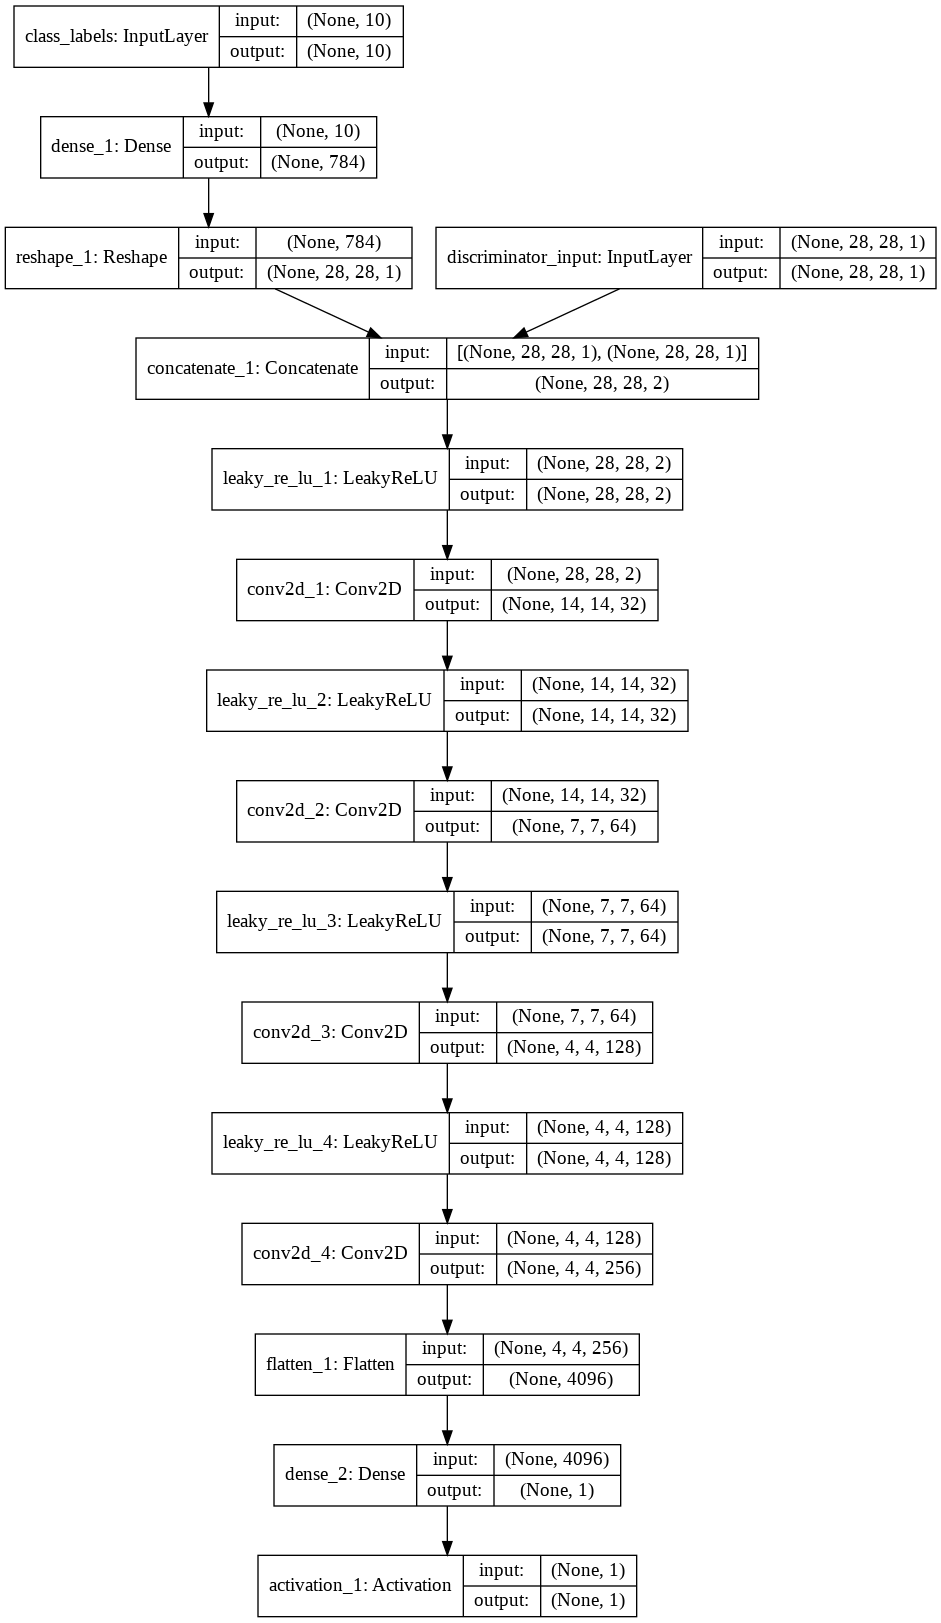

In [10]:
kernel_size = 5
layer_filters = [32, 64, 128, 256]

x = inputs

y = Dense(input_shape[0] * input_shape[1])(labels)
y = Reshape((input_shape[0], input_shape[1], 1))(y)
x = concatenate([x, y])
for filters in layer_filters:
  if filters == layer_filters[-1]:
      strides = 1
  else:
      strides = 2
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)

x = Flatten()(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

discriminator = Model([inputs, labels], x, name='discriminator')
optimizer = RMSprop(lr=lr, decay=decay)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()
plot_model(discriminator, show_shapes=True)

In [11]:
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')

In [12]:
kernel_size = 5
layer_filters = [128, 64, 32, 1]
image_resize = image_shape[1] // 4, image_shape[2] // 4

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         696192      concatenate_2[0][0]      

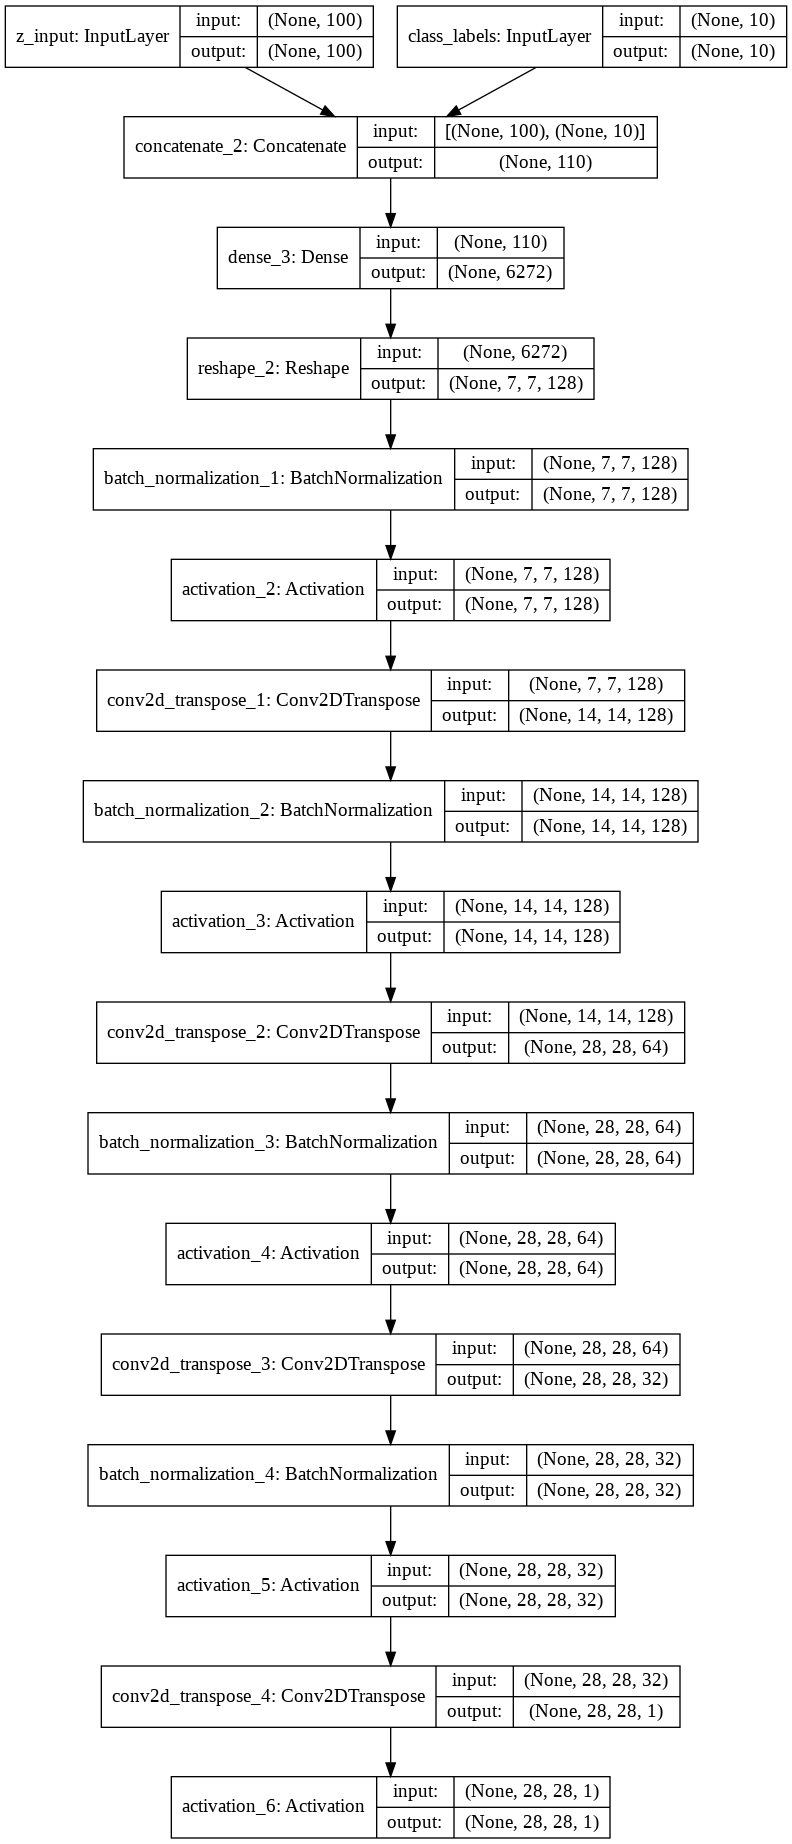

In [13]:
x = concatenate([inputs, labels], axis=1)
x = Dense(image_resize[0] * image_resize[1] * layer_filters[0])(x)
x = Reshape((image_resize[0], image_resize[1], layer_filters[0]))(x)

for filters in layer_filters:
    # first two convolution layers use strides = 2
    # the last two use strides = 1
    if filters > layer_filters[-2]:
        strides = 2
    else:
        strides = 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same')(x)

x = Activation('sigmoid')(x)
# input is conditioned by labels
generator = Model([inputs, labels], x, name='generator')
generator.summary()
plot_model(generator, show_shapes=True)

Model: "cgan_minst"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 28, 28, 1)    1364225     z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1090001     generator[1][0]         

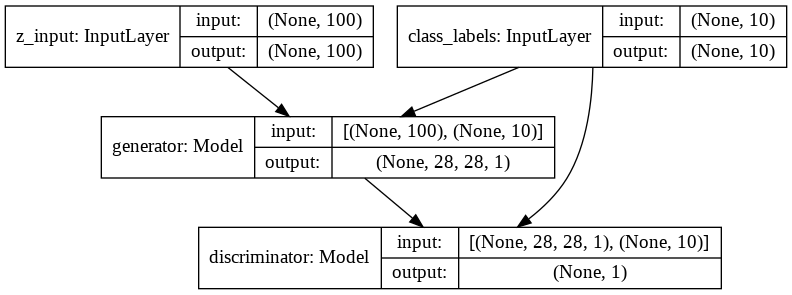

In [14]:
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
outputs = discriminator([generator([inputs, labels]), labels])
adversarial = Model([inputs, labels],
                    outputs,
                    name="cgan_minst")
adversarial.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()
plot_model(adversarial, show_shapes=True)

In [15]:
save_interval = 50
noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
train_size = x_train.shape[0]

In [16]:
def plot_images(generator,
                noise_input,
                noise_class,
                fig,
                out):
  
    images = generator.predict([noise_input, noise_class])
    plt.clf()
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
    with out:
        out.clear_output(wait=True)
        display(fig)

In [19]:
%matplotlib inline
%config InlineBackend.close_figures=False 

import ipywidgets as widgets

plt.ioff()
fig, ax = plt.subplots(figsize=(4, 4))

out=widgets.Output()
vbox=widgets.VBox([out])
display(vbox)

for i in range(train_steps):
    # train the discriminator for 1 batch
    # 1 batch of real (label=1.0) and fake images (label=0.0)
    # randomly pick real images from dataset
    rand_indexes = np.random.randint(0, train_size, size=batch_size)
    real_images = x_train[rand_indexes]
    # corresponding one-hot labels of real images
    real_labels = y_train[rand_indexes]
    # generate fake images from noise using generator
    # generate noise using uniform distribution
    noise = np.random.uniform(-1.0,
                              1.0,
                              size=[batch_size, latent_size])
    # assign random one-hot labels
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                      batch_size)]

    # generate fake images conditioned on fake labels
    fake_images = generator.predict([noise, fake_labels])
    # real + fake images = 1 batch of train data
    x = np.concatenate((real_images, fake_images))
    # real + fake one-hot labels = 1 batch of train one-hot labels
    labels = np.concatenate((real_labels, fake_labels))

    # label real and fake images
    # real images label is 1.0
    y = np.ones([2 * batch_size, 1])
    # fake images label is 0.0
    y[batch_size:, :] = 0.0
    # train discriminator network, log the loss and accuracy
    loss, acc = discriminator.train_on_batch([x, labels], y)
    log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

    # train the adversarial network for 1 batch
    # 1 batch of fake images conditioned on fake 1-hot labels 
    # w/ label=1.0
    # since the discriminator weights are frozen in 
    # adversarial network only the generator is trained
    # generate noise using uniform distribution        
    noise = np.random.uniform(-1.0,
                              1.0,
                              size=[batch_size, latent_size])
    # assign random one-hot labels
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                      batch_size)]
    # label fake images as real or 1.0
    y = np.ones([batch_size, 1])
    # train the adversarial network 
    # note that unlike in discriminator training, 
    # we do not save the fake images in a variable
    # the fake images go to the discriminator input
    # of the adversarial for classification
    # log the loss and accuracy
    loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
    log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
    # print(log)
    if (i + 1) % save_interval == 0:
        # plot generator images on a periodic basis
        plot_images(generator,
                    noise_input=noise_input,
                    noise_class=noise_class,
                    fig=fig,
                    out=out)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [21]:
%matplotlib inline
%config InlineBackend.close_figures=False 

plt.ioff()
fig, ax = plt.subplots(figsize=(4, 4))

out=widgets.Output()
vbox=widgets.VBox([out])
display(vbox)

noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

num_labels = 10
noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]

print(noise_class)
plot_images(generator,
            noise_input=noise_input,
            noise_class=noise_class,
            fig=fig,
            out=out)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
